# Example 3.2 (univariate Gaussian, $\sigma^2$ fixed)

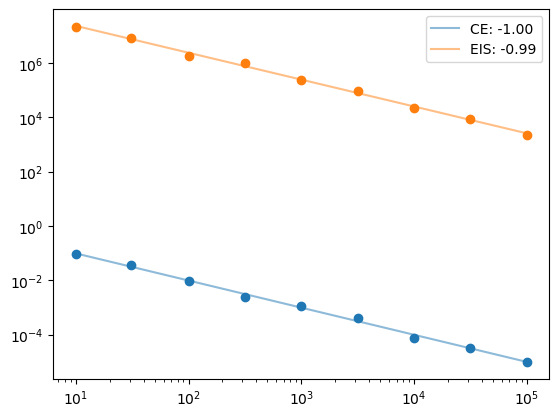

In [1]:
from jax.scipy.optimize import minimize
import jax.numpy as jnp
import jax.scipy as jsp
from tensorflow_probability.substrates.jax.distributions import TruncatedNormal, Normal
import jax.random as jrn
import matplotlib.pyplot as plt
from jax import vmap
from functools import partial

def ce_mu(samples, weights):
    mu = jnp.sum(samples * weights)/jnp.sum(weights)
    return mu

def eis_mu(samples, weights, logp, s2):
    N, = weights.shape
    X = jnp.array([jnp.ones(N), samples/jnp.sqrt(s2)]).reshape((2, N)).T

    wX = jnp.einsum('i,ij->ij', jnp.sqrt(weights), X)
    logh =  Normal(0, jnp.sqrt(s2)).log_prob(samples)
    y = jnp.sqrt(weights) * (logp - logh)
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    mu = beta[1] * jnp.sqrt(s2)
    return mu

def mu_ce_eis(N, key, s2, P):
    key, sk = jrn.split(key)

    samples = P.sample(N, sk)
    weights = jnp.ones(N)

    return jnp.array([
        ce_mu(samples, weights), 
        eis_mu(samples, weights, P.log_prob(samples), s2)
    ])


key = jrn.PRNGKey(10)
key ,*keys = jrn.split(key, 101)

keys = jnp.array(keys)

Ns = jnp.logspace(1, 5, 9).astype(int)

tau2 = 1.
s2 = 10000.

normal_estimators = partial(mu_ce_eis, P=Normal(0., jnp.sqrt(tau2)))

vars = jnp.array([
  (vmap(normal_estimators, (None, 0, None))(N, keys, s2)).var(axis=0)
  for N in Ns
])

coef_ce = jnp.polyfit(jnp.log(Ns), jnp.log(vars[:,0]), 1)
coef_eis = jnp.polyfit(jnp.log(Ns), jnp.log(vars[:,1]), 1)

plt.scatter(Ns, vars[:,0])
plt.scatter(Ns, vars[:,1])

plt.plot(Ns, jnp.exp(coef_ce[1]) * Ns ** coef_ce[0], label=f"CE: {coef_ce[0]:.2f}", alpha=.5)
plt.plot(Ns, jnp.exp(coef_eis[1]) * Ns ** coef_eis[0], label=f"EIS: {coef_eis[0]:.2f}", alpha=.5)

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [173]:
from tensorflow_probability.substrates.jax.distributions import MixtureSameFamily, Normal, Categorical
import tikzplotlib 
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command
def normal_are(s2, tau2, N, key, N_var):

    key, *keys = jrn.split(key, N_var + 1)
    keys = jnp.array(keys)

    normal_estimators = partial(mu_ce_eis, P=Normal(0., jnp.sqrt(tau2)))
    
    var_ce, var_eis = (vmap(normal_estimators, (None, 0, None))(N, keys, s2)).var(axis=0)
    return var_ce/var_eis

def mixture_are(s2, tau2, N, key, N_var):
    key, *keys = jrn.split(key, N_var + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([.5, .5])),
        components_distribution=Normal(jnp.array([-1., 1.]), jnp.sqrt(tau2))
    )
    mixture_estimators = partial(mu_ce_eis, P=P)
    
    var_ce, var_eis = (vmap(mixture_estimators, (None, 0, None))(N, keys, s2)).var(axis=0)
    return var_ce/var_eis

## `tikz/normal_are_sigma.tex`

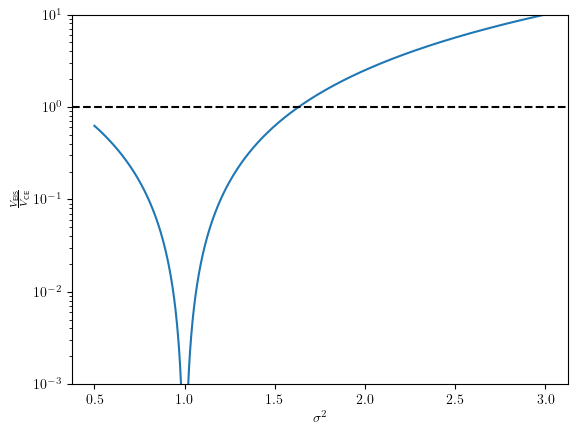

In [179]:

tau2 = 1.
sigmas = jnp.linspace(.5 * tau2, 3. * tau2, 1001)
v_ce = tau2 / sigmas
b_eis = sigmas / tau2
m_eis = 5/2 * (tau2 / sigmas) * (tau2/sigmas - 1)**2
v_eis = b_eis * m_eis * b_eis

analytic_are = v_eis/v_ce
plt.plot(sigmas, analytic_are, label="analytic")
plt.ylim(10**-3, 10**1)
plt.axhline(1., color="black", linestyle="--")

#plt.title(f"$\\tau^2$ = {tau2}")
plt.ylabel("$\\frac{V_{\\text{EIS}}}{V_{\\text{CE}}}$")
plt.xlabel("$\\sigma^2$")
plt.yscale("log")

#tikzplotlib.clean_figure()
tikzplotlib.save("../tikz/normal_are_sigma.tex")
plt.show()

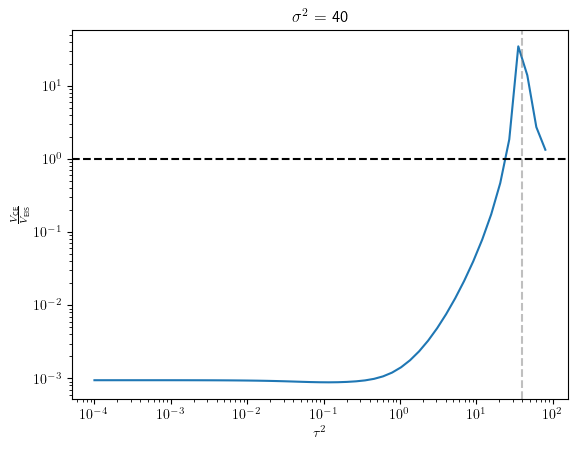

In [166]:
s2 = 40

taus = jnp.logspace(-4, jnp.log(2*s2) / jnp.log(10), 51)
ares = vmap(mixture_are, (None, 0, None, None, None))(s2, taus, int(1e4), subkey, 100)
plt.plot(taus, ares)
if s2 > 1.0:
    plt.axvline(s2 - 1, color="grey", linestyle="--", alpha=.5)
plt.axhline(1., color="black", linestyle="--")
plt.ylabel("$\\frac{V_{\\text{CE}}}{V_{\\text{EIS}}}$")
plt.xlabel("$\\tau^2$")
plt.title(f"$\\sigma^2$ = {s2}")

plt.yscale("log")
plt.xscale("log")
plt.show()


In [167]:

def ce_s2(samples, weights, mu):
    s2 = jnp.sum((samples - mu)**2 * weights) / jnp.sum(weights)
    return s2

def eis_s2(samples, weights, logp):
    N, = weights.shape
    X = jnp.array([jnp.ones(N), samples**2]).T

    wX = jnp.einsum('i,ij->ij', jnp.sqrt(weights), X)
    y = jnp.sqrt(weights) * logp
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    s2 = -1 / 2 / beta[2]
    return s2

# Example 3.3 (univariate Gaussian, $\mu$ fixed)

$\providecommand{\P}{\mathbf P}$
For the asymptotic variance of EIS:
$$
\mathbf P \left(  \left( \operatorname{id} - \mu \right)^{4} \left( \operatorname{id}^{2} \underbrace{\left( -\frac{1}{2\tau^{2}} - \psi\right)}_{=a} - \tau^{2} \left(-\frac{1}{2\tau^{2}} - \psi \right) \right)^2 \right) = a^{2} \mathbf P \left(  \left( \operatorname{id} - \mu \right)^{4} \left( \operatorname{id}^{2} - \tau^{2} \right)^{2} \right) 
$$
for $\P = \mathcal N (0,\tau^{2})$

In [168]:
from IPython.display import display, Latex
from sympy import symbols, lambdify
from sympy.stats import Normal, E
from sympy.printing.latex import latex

def show(lhs, expr):
    display(Latex("$" + lhs + " = " + latex(expr) + "$"))

mu, tau = symbols("mu tau")
X = Normal("x", 0, tau) # X ~ P
T = (X - mu)**2
ET = E(T)
Cov_T = (E(T**2) - ET**2).simplify()

#display(Latex("$\\mathbf P T$"))
show("\\mathbf P T", ET)
show("\\text{Cov} (T)", Cov_T)
# CE
psi_ce = -1/(2 * (tau**2 + mu**2))
show("\\psi_{\\text{CE}}", psi_ce)
I_ce = 1/ (2 * psi_ce **2)
B_ce = 1/I_ce
M_ce = Cov_T
V_ce = B_ce * M_ce * B_ce
show("V_{\\text{CE}}", V_ce)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [169]:
# EIS
logp = -1/2 * X**2/tau**2
CovT_logp = E((T - ET)*(logp - E(logp)))
show("\\text{Cov}(T, \\log p)", CovT_logp)
psi_eis = 1/Cov_T * CovT_logp
show("\\psi_{\\text{EIS}}", psi_eis)
a = (-1/2/tau**2 - psi_eis)
#integral = E((X-mu)** 4 * (X**2 - tau**2)**2)
logw = -1/2 * X**2 / tau**2 - psi_eis * T
M_eis = E((X - mu)**4 * (logw - E(logw))**2)#a ** 2 * integral
nu = 3 * tau ** 4
B_eis = 1/Cov_T

V_eis = B_eis * M_eis * B_eis
show("V_{\\text{EIS}}", factor(V_eis.simplify()))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## `tikz/normal_are_mu.tex`

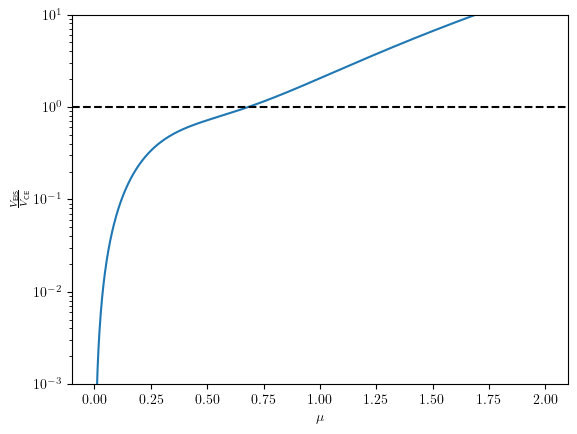

In [180]:
V_eis_fun = lambdify((mu, tau), V_eis, "jax")
V_ce_fun = lambdify((mu, tau), V_ce, "jax")

mus = jnp.linspace(0, 2, 1001)
veis = vmap(V_eis_fun, (0, None))(mus, 1.)
vce = vmap(V_ce_fun, (0, None))(mus, 1.)
plt.plot(mus, veis/vce)
plt.axhline(1., color="black", linestyle="--")
plt.ylabel("$\\frac{V_{\\text{EIS}}}{V_{\\text{CE}}}$")
plt.xlabel("$\\mu$")
plt.ylim(10**-3, 10**1)
plt.yscale("log")

tikzplotlib.save("../tikz/normal_are_mu.tex")
plt.show()

$\providecommand{\G}{\mathbf G}$
Second moment of weights for $\P = \mathcal N (\nu, \tau^2)$, $\G = \mathcal N (\mu, \sigma^2)$

<IPython.core.display.Latex object>

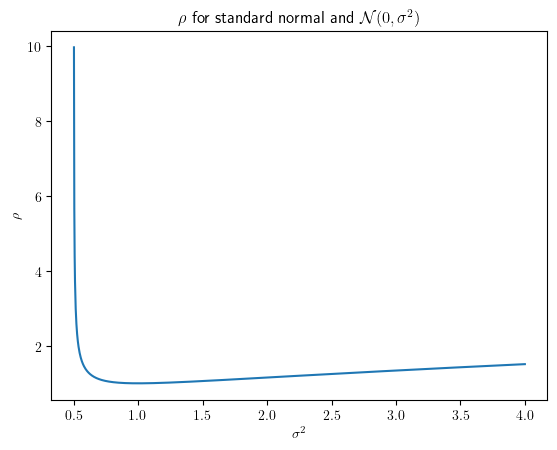

In [ ]:
from sympy import integrate, oo, exp, sqrt, pi, symbols, log
x, nu, mu, tau, sigma = symbols("x nu mu tau sigma")
X = Normal("x", nu, tau)
weights_exponent = -1/2 * (x - nu) ** 2 / tau ** 2 + 1/2 * (x - mu) ** 2 / sigma ** 2

a,b,c = symbols("a b c")
# int exp(-a x^2 + b x + c) dx
exponential_integral = sqrt(pi / a) * exp(b**2/4/a +c)

# second moment of weights under G, for P = N(nu, tau**2), G = N(mu, sigma**2)
# int p^2/g
rho_normal = exponential_integral.subs({
    a: 1/ tau**2  - 1/2/sigma**2,
    b: 2*nu/tau**2 - mu/sigma**2,
    c: -nu ** 2/ tau ** 2 + mu ** 2 / sigma ** 2 / 2 - log(tau ** 2) - log(2 * pi) + 1/2 * log(sigma ** 2) + 1/2 * log(2 * pi)
})
show("\\rho_{\\mathcal N(\\nu, \\tau^2), \\mathcal N(\\mu, \\sigma^2)}", rho_normal.simplify())

rho_normal_fun = lambdify((nu, tau, mu, sigma), rho_normal, "jax")
sigs =  jnp.linspace(.1, 2, 1001)
rhos = vmap(rho_normal_fun, (None, None, None, 0))(0., 1., 0.,sigs)
plt.title("$\\rho$ for standard normal and $\\mathcal N (0, \\sigma^2)$")
plt.plot(sigs**2, rhos)
plt.ylabel("$\\rho$")
plt.xlabel("$\\sigma^2$")
plt.show()

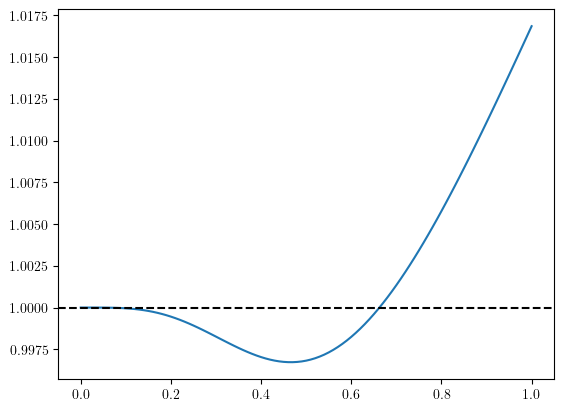

In [ ]:
sigma_ce_fun = lambdify((mu, tau), sqrt(-1/2/psi_ce), "jax")
sigma_eis_fun = lambdify((mu, tau), sqrt(-1/2/psi_eis), "jax")


mus = jnp.linspace(0, 1, 101)
sigma_ces = vmap(sigma_ce_fun, (0,None))(mus, 1.)
sigma_eiss = vmap(sigma_eis_fun, (0, None))(mus, 1.)
rho_ce = vmap(rho_normal_fun, (None, None, 0,0))(0., 1., mus, sigma_ces)
rho_eis = vmap(rho_normal_fun, (None, None, 0,0))(0., 1., mus, sigma_eiss)

plt.plot(mus, rho_eis/rho_ce)
plt.axhline(1., color="black", linestyle="--")
plt.show()